## Estimating TR-XSS Signals of the Korovina 2018 system - Further Studies

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os, sys, glob, matplotlib

%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('axes.formatter', limits= (-3, 3))
plt.rcParams.update({'font.size': 15})

import numpy as np
from ase import Atoms
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import Trajectory

# all things that can be installed with pip
import nglview as nv
from grsq import Debye
from noise_estimator import NoiseEstimator 
from analysis import Korovina, weigh
from tqdm.notebook import tqdm

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Experimenting with different ranges of twists

In [2]:
aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')
nv.show_asetraj(aligned_traj)

NGLWidget(max_frame=20207)

In [3]:
ehex_s0_thf_a = np.zeros(len(aligned_traj))
for i, atoms in enumerate(aligned_traj):
    tmp = Korovina(mol='ehex')
    ehex_s0_thf_a[i] = tmp.calc_angle(atoms)

In [4]:
def calc_scat(aligned_traj, ad, es_angle, qvec=None, calc_gs=True):
    mask_cop = np.zeros(len(aligned_traj), bool)
    mask_cop[(ehex_s0_thf_a < ad) | (ehex_s0_thf_a > 360 - ad)] = True
    idx_cop = np.where(mask_cop)[0]
    cop_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_cop]

    mask_twi = np.zeros(len(aligned_traj), bool)
    mask_twi[(ehex_s0_thf_a > es_angle - ad) & (ehex_s0_thf_a < es_angle + ad)] = True
    idx_twi = np.where(mask_twi)[0]
    twi_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_twi]
    
    if qvec is None:
        qvec = np.arange(0, 5, 0.02)
    deb = Debye(qvec=qvec)

    sq_es = np.zeros((len(twi_dist), len(qvec)))
    sq_gs = np.zeros((len(cop_dist), len(qvec)))

    if calc_gs:
        for i, atoms in tqdm(enumerate(cop_dist), total=len(cop_dist)): # GS
            sq_gs[i] = deb.debye_numba(atoms)

    for i, atoms in tqdm(enumerate(twi_dist), total=len(twi_dist)): # ES
        sq_es[i] = deb.debye_numba(atoms)
    
    return sq_gs, sq_es, mask_cop, mask_twi, twi_dist

Calculate the scattering signal from more twist angles

In [5]:
ne = NoiseEstimator(accu_time=600, photons_pulse=1e11, reprate=100)
#noise_diff = ne.calc_noise()
qvec = ne.qvec

aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')

energies = np.genfromtxt('data/energies.dat')[:, 0]

ad = 2.5  # 

angles = list(range(5, 95, 5))
all_weighed_es = np.zeros((len(angles), len(qvec)))

twist_dists = [[] for i in range(len(angles))]
for i, angle in enumerate(angles):
    if i == 0:
        sq_gs, sq_es, mask_cop, mask_twi, twi_dist = calc_scat(aligned_traj, ad, angle, qvec=qvec)
    else:
        _, sq_es, mask_cop, mask_twi, twi_dist = calc_scat(aligned_traj, ad, angle, qvec=qvec, calc_gs=False)

    gs_weighed = np.sum(sq_gs * weigh(energies, mask=mask_cop), axis=0)
    es_weighed = np.sum(sq_es * weigh(energies, mask=mask_twi), axis=0)
    
    all_weighed_es[i, :] = es_weighed
    
    twist_dists[i] = twi_dist



  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

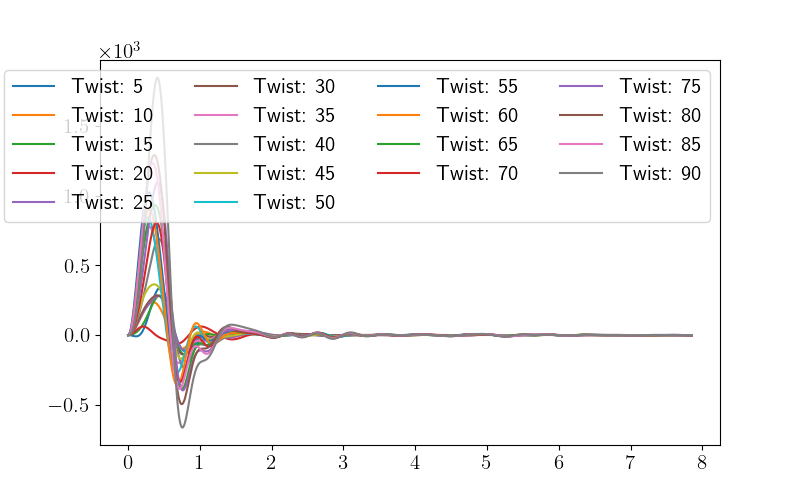

In [6]:
col = make_colors(len(angles))
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for a, es_ang in enumerate(all_weighed_es):
    ax.plot(qvec, es_ang  - gs_weighed, color=f'C{a}', label=f'Twist: {angles[a]:2.0f}')
    
ax.legend(loc='best', ncol=4)

add noise

In [7]:
ne = NoiseEstimator(accu_time=600, photons_pulse=1e11, reprate=100)
noise_diff = ne.calc_noise()

  0%|          | 0/60000 [00:00<?, ?it/s]

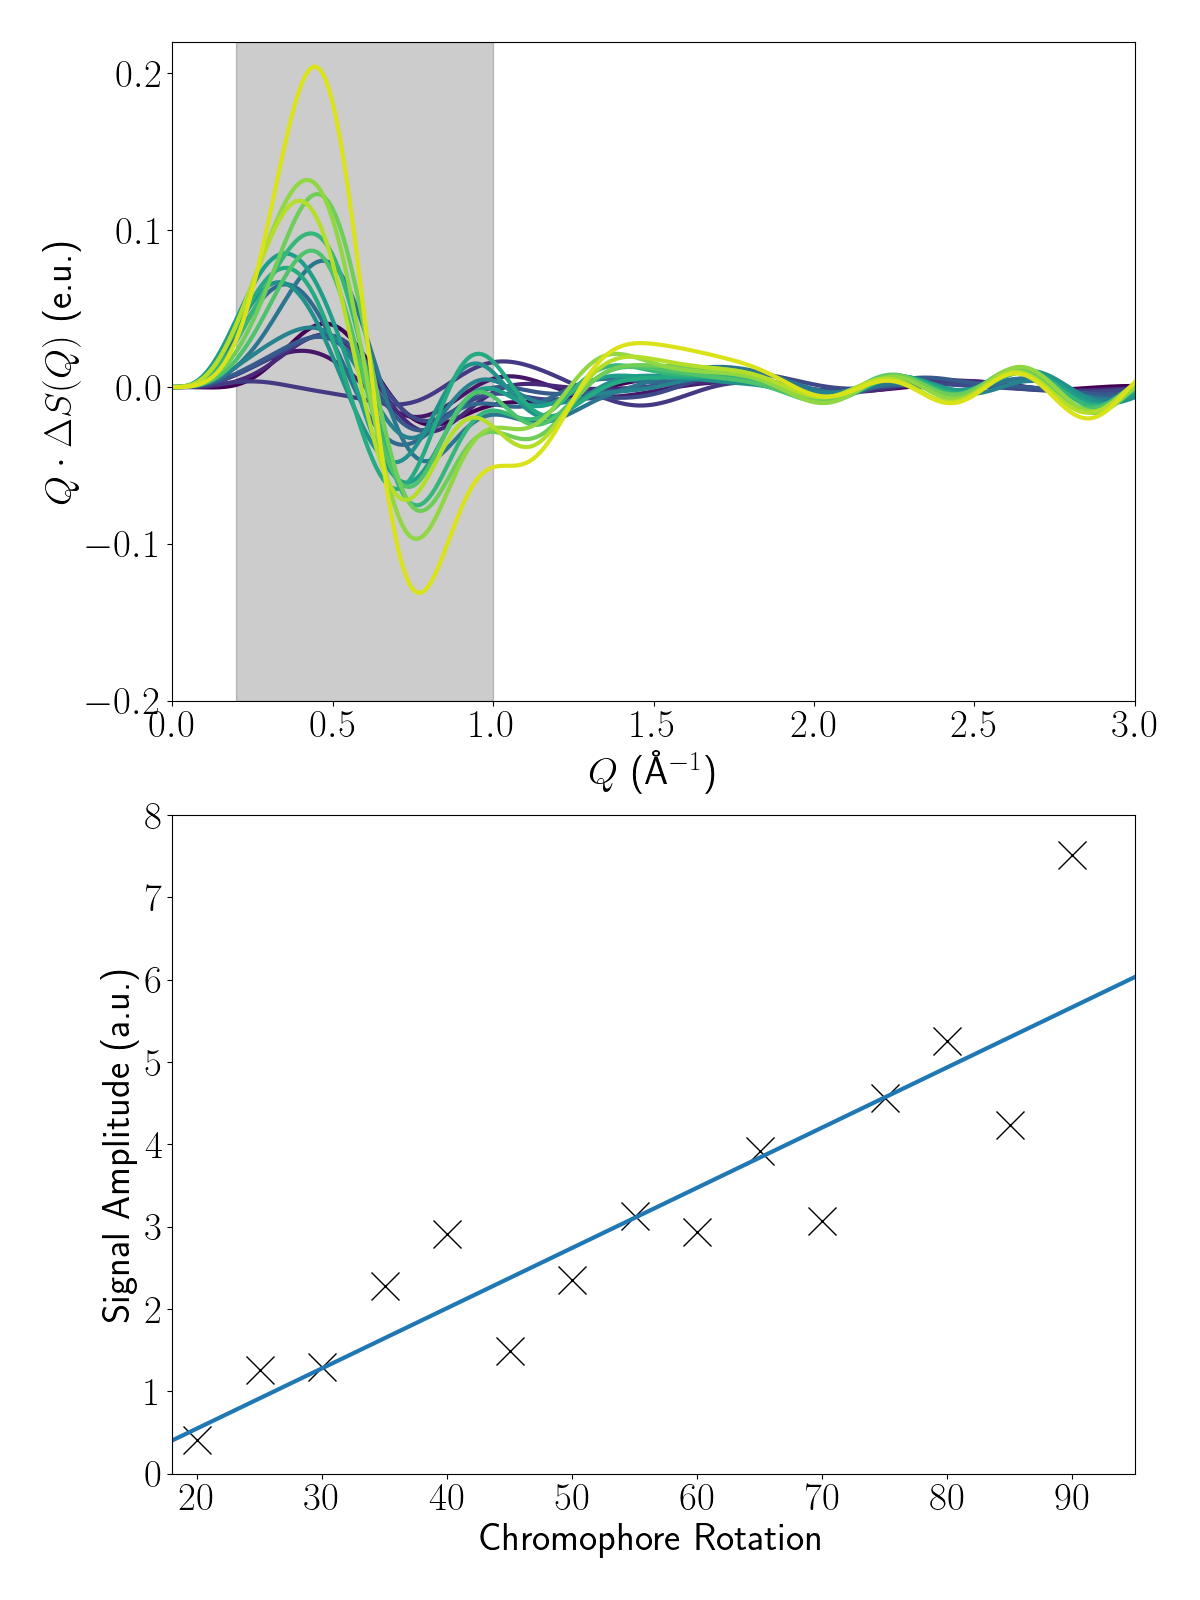

In [13]:
plt.rcParams.update({'font.size': 28})

# Sample parameters
dens = 779    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 12     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want

exp_scale = frac_exc * frac_yield / conc_scale


col = make_colors(len(twist_dists))
#hti = np.genfromtxt('ref/htij_ds_ct_90twist_acn_sim.dat', skip_header=1)

qmask = np.zeros(len(qvec), bool)
qmin = 0.2
qmax = 1
qmask[(qvec > qmin) & (qvec < qmax)] = True

lel = np.zeros(len(twist_dists))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for a, es_ang in enumerate(all_weighed_es):
    ax = axes[0]
    #ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale + noise_diff),
    #        color=col[a], alpha=0.25, lw=3)

    ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale),
            color=col[a], label=f'Twist: {angles[a]:2.0f}$^\circ$', lw=3)

    
    lel[a] = np.nanmean( (qvec *((es_ang  - gs_weighed) * exp_scale))[qmask])
    lel[a] = np.sum( np.abs(qvec *((es_ang  - gs_weighed) * exp_scale))[qmask])
    
#ax.plot(hti[:, 0], hti[:, 0] * hti[:, 2], 'C3--', label=f'HTI-J')
ax.axvspan(qmin, qmax, color='k', alpha=0.2)



handles, labels = ax.get_legend_handles_labels()
# Filter to only include every 6th handle and label for the legend
#filtered_handles = [h for i, h in enumerate(handles) if i % 3 == 0]
#filtered_labels = [l for i, l in enumerate(labels) if i % 3 == 0]

ax.set_xlim([0, 3.0])
ax.set_ylim([-.20, .22])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (e.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
#ax.legend(loc='lower right')
#ax.legend(loc='best', ncol=2)
#ax.legend(filtered_handles, filtered_labels, loc='best', ncol=2)
angles = np.array(angles)

coeff = np.polyfit(angles[angles > 18], lel[angles > 18], 1)
polynomial = np.poly1d(coeff)
x = np.arange(0, 180, 1)
fit_values = polynomial(x)

ax = axes[1]
ax.plot(angles, lel, 'kx', ms=20)
ax.plot(x, fit_values, lw=3)
ax.set_xlim([18, 95])
ax.set_ylim([0, 8])
ax.set_xlabel('Chromophore Rotation')
ax.set_ylabel('Signal Amplitude (a.u.)')


fig.tight_layout(h_pad=0.2)

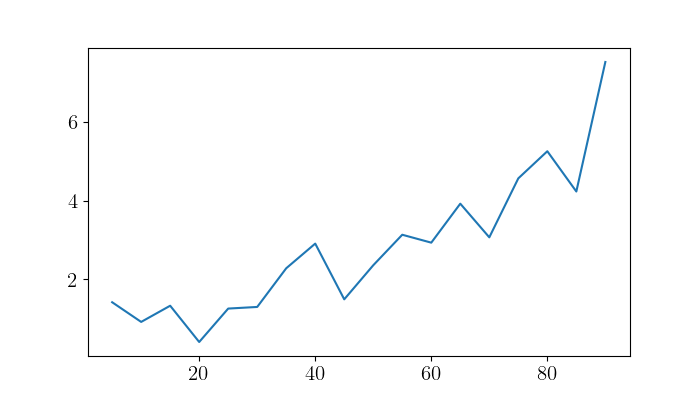

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(angles, lel)

In the plot above, the scattering signal is predicted by calculating a Boltzmann-weighed average of the Debye-scattering from a conformer ensemble generated with tight-binding DFT, using the calculated electronic energies of each individual conformer. For each twisting angle, we performed the weighed average on all sampled conformers within $\pm$ 5$^\circ$ of the twist reported in the legend. In this way we take into account the scattering from many possible conformations of the two side-groups of ehex, providing a more nuanced prediction than if simply calculating the scattering from two discrete structures (1 for the ground state and 1 for the excited state). In the plot above, the ground state scattering is also calculated from a $\pm$ 5$^\circ$ weighed window of ground state conformers around 0 degrees twist. 

# Selecting conformers for explicit solvent shell sampling
We decided on the following: 
1. $\omega$-parametrization of the chromophore-rotations
2. $\omega = [0, 15, 30, 45, 60, 75, 90]$  degrees of the S0 conformer first. 

We can have a situation where I have a conformer with $\omega = 14^\circ$ that has _much_ lower energy than my $\omega = 15^\circ$ conformer. In such a case, the correct choice is the 14 degree conformer, because we cannot discern between a few degrees, but for this conformer, the R-groups much be in a much more stable location. 

Therefore:

1. For each chosen $\omega$ find the _lowest_-energy conformer within $\Delta \omega = \pm 1.5$ degrees

For this we need _all_ the crest conformer sets (ehex/ohex, (s0/q1)). In another notebook outside of this repo (`~/Dropbox/DTU2/Pentacene/FINAL/2024_CLEAN_Korovina.ipynb`) I've created a npy datafile with all conformers, scattering curves, and sampled angles. It's too big for this repo, so let's get it:

In [9]:
!wget -O data/crest.npy "https://dl.dropboxusercontent.com/scl/fi/ozymqa3h2o722h7a82eft/crest.npy?rlkey=zu5tp8ec1j2ve3l172fj5lc2p&dl=1"

--2024-05-07 11:12:41--  https://dl.dropboxusercontent.com/scl/fi/ozymqa3h2o722h7a82eft/crest.npy?rlkey=zu5tp8ec1j2ve3l172fj5lc2p&dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.69.15, 2620:100:6022:15::a27d:420f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.69.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762684310 (727M) [application/octet-stream]
Saving to: ‘data/crest.npy’

data/crest.npy      100%[===================>] 727.35M  24.8MB/s    in 30s     

2024-05-07 11:13:12 (24.5 MB/s) - ‘data/crest.npy’ saved [762684310/762684310]



In [3]:
crest = np.load('data/crest.npy', allow_pickle=True).item()

In [4]:
crest.keys(), crest['ehex']['s0'].keys()

(dict_keys(['ehex', 'ohex']),
 dict_keys(['traj', 'energies', 't1', 't2', 'w', 'aligned', 'phis', 'psis', 'part0_dgtot', 'chis', 'gammas']))

### Overview of keys:
| **Variable**     | **Description**                                                                                         |
|------------------|--------------------------------------------------------------------------------------------------------|
| **traj**         | List of ASE Atoms objects of conformers.                                                               |
| **energies**     | XTB energies.                                                                                          |
| **t1**           | θ₁ dihedral.                                                                                           |
| **t2**           | θ₂ dihedral.                                                                                           |
| **w**            | ω = |θ₁| + |θ₂|.                                                                                       |
| **aligned**      | Same as traj, but the conformers are aligned to the bridge atoms, which makes visual inspection easier.|
| **phis**         | φ-angle between r-vector (see image below) and bridge normal.                                         |
| **psis**         | ψ-angle.                                                                                               |
| **part0_dgtot**  | Energies from CENSO part0: B97-D3(0)/def2-SV(p) CPCM(THF) SPs on XTB geometries.                       |
| **chis**         | Dot product between r-vector (same as for φ) and plane normal.                                         |
| **gamma**        | γ-angle.                                                                                               |


#### $\phi$-angle
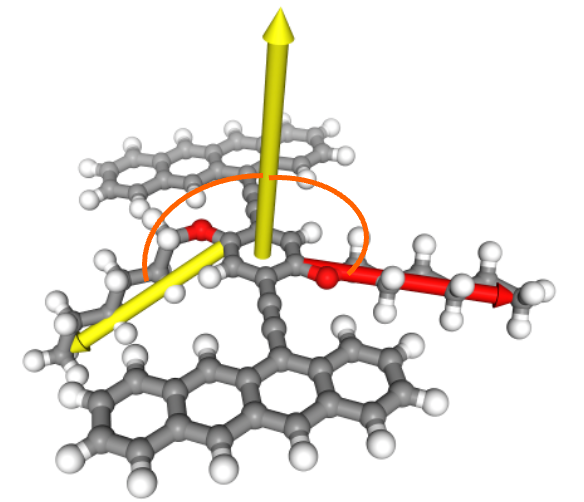

#### $\psi$-angle
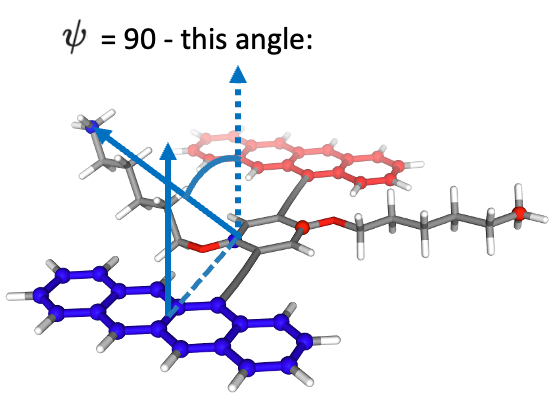

#### $\gamma$-angle:
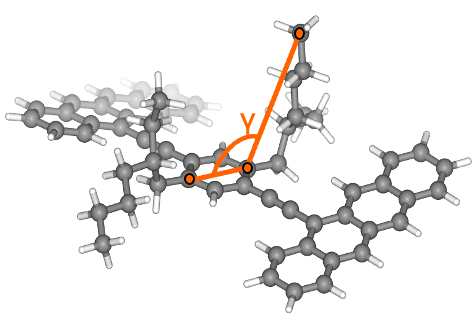


### Find most stable conformer within $\pm 1.5$ degrees of each chosen $\omega$

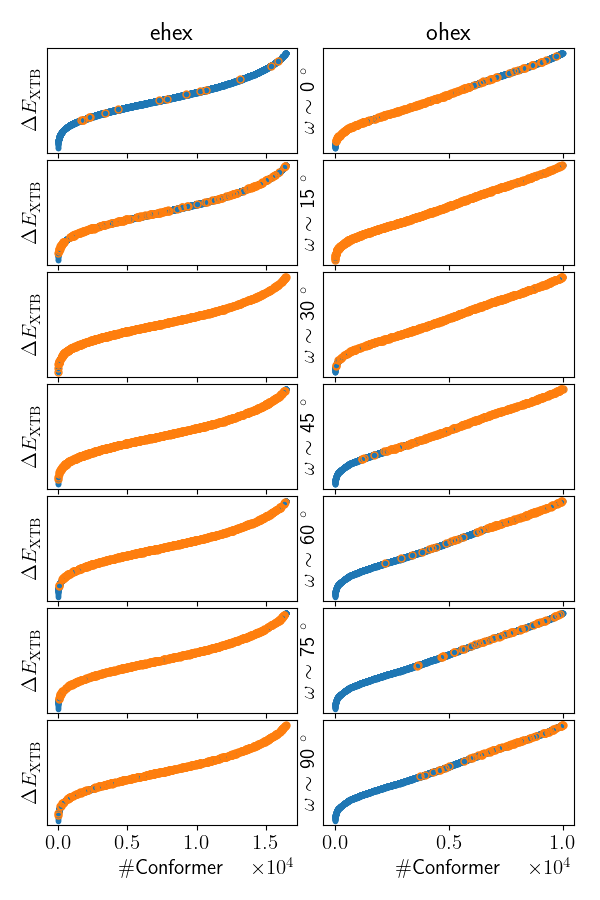

In [5]:
angles = [0, 15, 30, 45, 60, 75, 90]

stable_conformers = {mol: {angle:{'atoms':None, 'energies':None, 'w':None} 
                           for angle in angles} 
                     for mol in ['ehex', 'ohex']}                

fig, axes = plt.subplots(7, 2, figsize=(6, 9))
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            w = crest[mol][state]['w']
            e = crest[mol][state]['energies']
            mask = np.isclose(w, angle, atol=1.5 if angle > 0 else 3)

            ax = axes[a, m]
            x = np.arange(len(e))
            ax.plot(x, e, '.')
            ax.plot(x[mask], e[mask], 'C1o', mfc='None', ms='5')

            stable_conformers[mol][angle]['atoms'] = [atoms for i, atoms in enumerate(crest[mol][state]['aligned']) if mask[i]]
            stable_conformers[mol][angle]['energies'] = crest[mol][state]['energies'][mask]
            stable_conformers[mol][angle]['w'] = crest[mol][state]['w'][mask]

for ax in axes[:, 1]:
    ax.set_yticklabels('')
for ax in axes[:-1, :].ravel():
    ax.set_xticklabels('')
for ax in axes.ravel():
    ax.set_yticks([])

for i, angle in enumerate(angles):
    axes[i, 0].set_ylabel('$\Delta E_\mathrm{XTB}$')
    axes[i, 1].set_ylabel(f'$\omega \sim$ {angle:d} $^\circ$')
axes[0, 0].set_title('ehex')
axes[0, 1].set_title('ohex')
for ax in axes[-1, :]:
    ax.set_xlabel('\#Conformer')
fig.tight_layout(w_pad=0.1, h_pad=0.1)

For $\omega$-angles below 45 degrees, both molecules have conformations in the low end of the energy range (0-6 kcal/mol). For angles above, ohex does not. This is basically just another representation of the $\omega$ density-plots: 

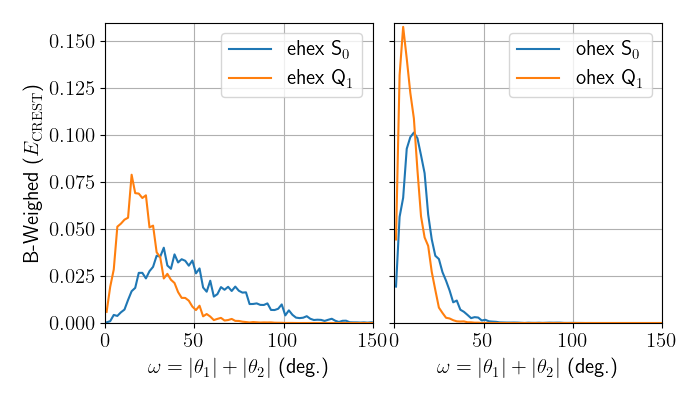

In [6]:
def w_hist(angles, energies):
    hist, bins = np.histogram(angles, 
                              bins=np.arange(-0, 182, 2), 
                              density=False,
                              weights=weigh(np.array(energies)).squeeze())
    return bins, hist

states = {'s0': 'S$_0$', 'q1': 'Q$_1$'}

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
for m, mol in enumerate(['ehex', 'ohex']):
    ax = axes[m]
    for st, state in enumerate(['s0', 'q1']):
        c = crest[mol][state]
        bins, hist = w_hist(c['w'], c['energies'])
        ax.plot(bins[1:] - 0.5 * np.diff(bins)[0], hist, label=f'{mol} {states[state]}', ls='-', color=f'C{st}')

axes[1].set_yticklabels([])
axes[0].set_ylabel('B-Weighed ($E_\\mathrm{CREST}$)')

for ax in axes:
    ax.grid()
    ax.legend(loc='best')
    ax.set_xlim([0, 150])
    ax.set_ylim([0, 0.16])
    ax.set_xlabel('$\\omega = |\\theta_1| + |\\theta_2|$ (deg.)')    
fig.tight_layout(w_pad=0.05)

Juust before we collect the geometries to be restrained and solvent-shell-sampled with MD, let us _look_ at e.g. all 15 of ehex

In [7]:
nv.show_asetraj(stable_conformers['ehex'][15]['atoms'])

NGLWidget(max_frame=184)

Seems like they have both in-bridge-plane and out-of-bridge-plane R-groups. Let us look at the most stable

In [8]:
most_stable = []
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            conformers = stable_conformers[mol][angle]['atoms']
            e = stable_conformers[mol][angle]['energies']
            min_idx = np.argmin(e)

            most_stable.append(conformers[min_idx])
        

In [9]:
nv.show_asetraj(most_stable[:7])

NGLWidget(max_frame=6)

The problem here is that they flip between parallel and antiparralel. 

So we need to define a direction for the tetracene rotation

In [10]:
#traj = crest['ohex']['s0']['aligned']
traj = most_stable[:7]
v = view(traj, viewer='ngl')
v.children[0].clear()
v.children[0].add_representation('licorice')
v.children[0].add_label(labelType="atomindex", color='red')
v

In [11]:
def get_direction(atoms):
    idx1 = [18, 6]  # same for ohex and ehex
    idx2 = [48, 49] # ditto.

    pos = atoms.get_positions()
    v1 = pos[idx1[1]] - pos[idx1[0]]
    v2 = pos[idx2[1]] - pos[idx2[0]]

    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)

    return np.dot(v1, v2)

direction = np.zeros(len(traj))

for i, atoms in enumerate(traj):
    direction[i] = get_direction(atoms)
    

direction

array([ 0.99935011,  0.99788068, -0.99912839,  0.99882757,  0.50286084,
       -0.28113625, -0.01934634])

now the `direction` is negative for antiparallel, and positive for parallel conformers.

So let us once again: 

## Find most stable conformers within $\pm 1.5$ degrees of each chosen $\omega$ - both for Parallel and Antiparallel conformers

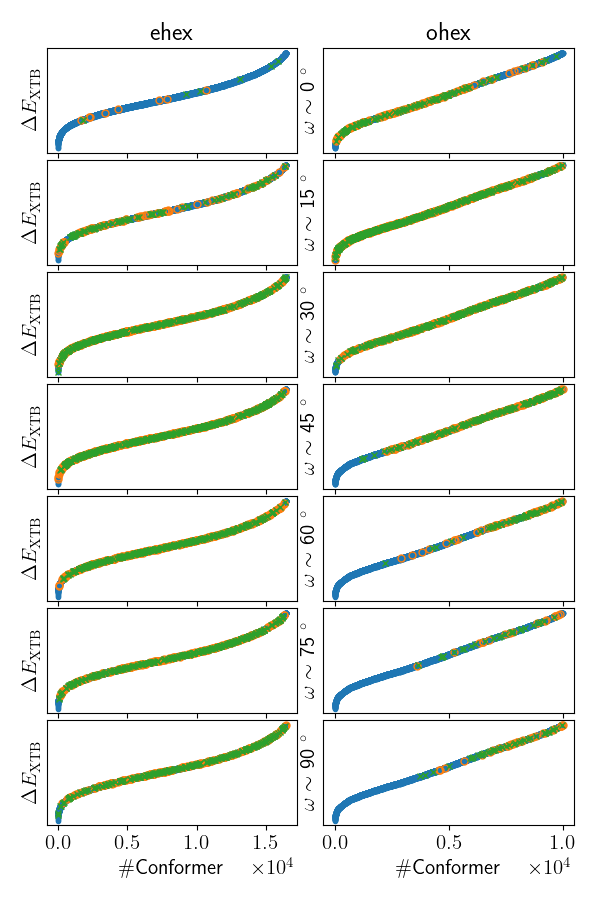

In [12]:
angles = [0, 15, 30, 45, 60, 75, 90]

stable_conformers_pp = {mol: {angle:{'atoms':None, 'energies':None, 'w':None} 
                           for angle in angles} 
                       for mol in ['ehex', 'ohex']}                

stable_conformers_ap = {mol: {angle:{'atoms':None, 'energies':None, 'w':None} 
                           for angle in angles} 
                       for mol in ['ehex', 'ohex']}                

stable_conformers = {1: stable_conformers_pp, 
                    -1: stable_conformers_ap}


fig, axes = plt.subplots(7, 2, figsize=(6, 9))
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for direction in [1, -1]:
            for a, angle in enumerate(angles):
                w = crest[mol][state]['w']
                e = crest[mol][state]['energies']
                d = np.array([get_direction(atoms) for atoms in crest[mol][state]['aligned']])
                              
                mask_w = np.isclose(w, angle, atol=1.5 if angle > 0 else 3)
                
                mask_d = np.zeros(len(d), bool)
                mask_d[d * direction > 0] = True
                #print(mask_d.sum(), len(mask_d))
    
                mask = mask_w * mask_d
    
                ax = axes[a, m]
                x = np.arange(len(e))
                
                if direction == 1:
                    ax.plot(x, e, 'C0.')
                    ax.plot(x[mask], e[mask], f'C1o', mfc='None', ms='5')
                elif direction == -1:
                    ax.plot(x[mask], e[mask], f'C2x', mfc='None', ms='5')
    
                stable_conformers[direction][mol][angle]['atoms'] = [atoms for i, atoms in enumerate(crest[mol][state]['aligned']) if mask[i]]
                stable_conformers[direction][mol][angle]['energies'] = crest[mol][state]['energies'][mask]
                stable_conformers[direction][mol][angle]['w'] = crest[mol][state]['w'][mask]

for ax in axes[:, 1]:
    ax.set_yticklabels('')
for ax in axes[:-1, :].ravel():
    ax.set_xticklabels('')
for ax in axes.ravel():
    ax.set_yticks([])

for i, angle in enumerate(angles):
    axes[i, 0].set_ylabel('$\Delta E_\mathrm{XTB}$')
    axes[i, 1].set_ylabel(f'$\omega \sim$ {angle:d} $^\circ$')
axes[0, 0].set_title('ehex')
axes[0, 1].set_title('ohex')
for ax in axes[-1, :]:
    ax.set_xlabel('\#Conformer')
fig.tight_layout(w_pad=0.1, h_pad=0.1)

In [13]:
most_stable = []
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for direction in [1, -1]:
            for a, angle in enumerate(angles):
                conformers = stable_conformers[direction][mol][angle]['atoms']
                e = stable_conformers[direction][mol][angle]['energies']
                min_idx = np.argmin(e)
    
                most_stable.append(conformers[min_idx])

In [14]:
nv.show_asetraj(most_stable)

NGLWidget(max_frame=27)

Also not very systematic in the rotations, but keeping in mind that the $\omega$ angle is the only parametrization of the chromophores that shows systematicity with respect to the absorption spectrum peak positions, then $\omega$ is really the angle that "matters", in the sense that it is via _this_ structural parameter that we can find a relationship between the geometric structure of the molecule and its function (as probed via absorption energies). 

Or put another way: Stabilizing the separated triplets as a "function" of the molecule. This happens when the pi-conjugation between chromophores is broken. This can just as easily happen by the BRIDGE rotating out of plane of the chromophores. 

**We should check what kind of a structural signal that gives.**

But first we should stick to our first grid-idea: span all possible rotations from PP 0 degrees to AP, in a clean(er) way. Let's try by keeping $\theta_1$ close to zero and search for $\theta_2$ values. This is closer to the hypothesized mechanism from Korovina

In [232]:
crest[mol][state]['t1'].min()

-89.95333123477937

In [240]:
mask_t1.sum()

3242

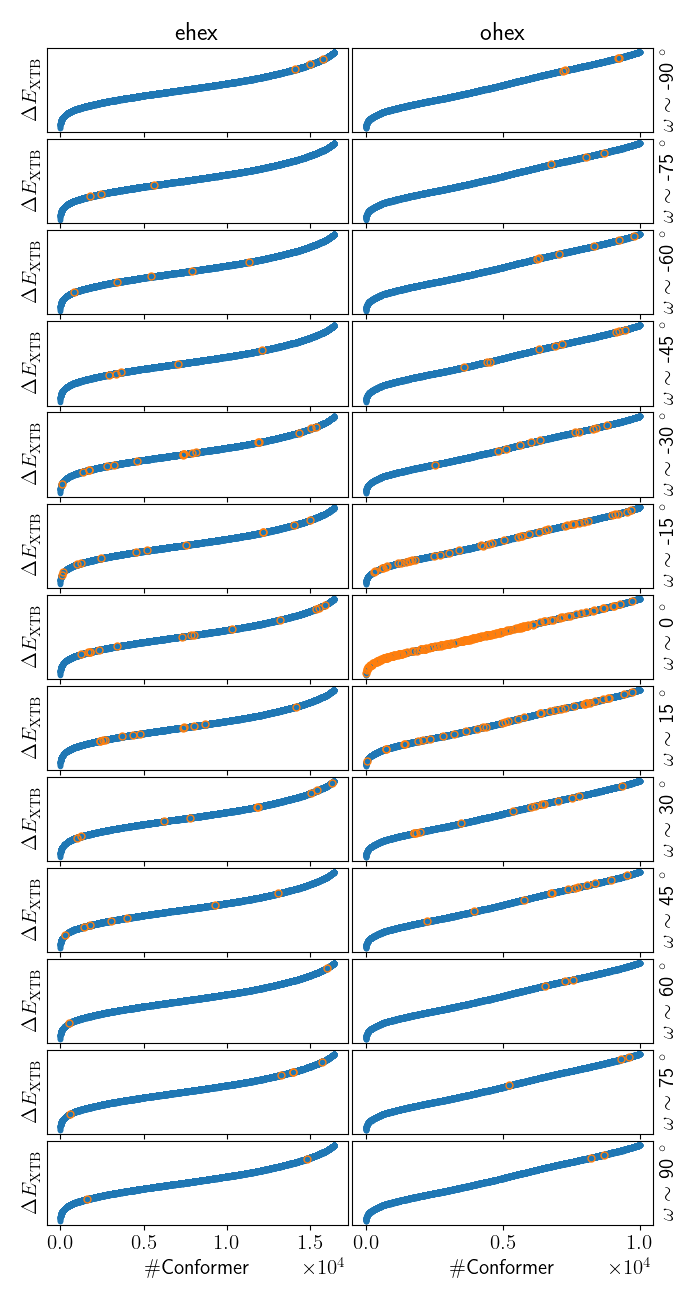

In [15]:
angles = np.arange(-90, 105, 15)

stable_conformers = {mol: {angle:{'atoms':None, 'energies':None, 'w':None} 
                           for angle in angles} 
                     for mol in ['ehex', 'ohex']}                

fig, axes = plt.subplots(len(angles), 2, figsize=(7, 13))
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            t1 = crest[mol][state]['t1']
            t2 = crest[mol][state]['t2']
            
            e = crest[mol][state]['energies']
            
            mask_t1 = np.isclose(t1, 0, atol=2.5)      # planar with bridge
            mask_t2 = np.isclose(t2, angle, atol=1.5)  # rotate

            mask = mask_t1 * mask_t2

            #print(angle, mask_t1.sum(), mask_t2.sum(), mask.sum())

            ax = axes[a, m]
            x = np.arange(len(e))
            ax.plot(x, e, '.')
            ax.plot(x[mask], e[mask], 'C1o', mfc='None', ms='5')

            stable_conformers[mol][angle]['atoms'] = [atoms for i, atoms in enumerate(crest[mol][state]['aligned']) if mask[i]]
            stable_conformers[mol][angle]['energies'] = crest[mol][state]['energies'][mask]
            stable_conformers[mol][angle]['w'] = crest[mol][state]['w'][mask]

for ax in axes[:, 1]:
    ax.set_yticklabels('')
for ax in axes[:-1, :].ravel():
    ax.set_xticklabels('')
for ax in axes.ravel():
    ax.set_yticks([])

for i, angle in enumerate(angles):
    axes[i, 0].set_ylabel('$\Delta E_\mathrm{XTB}$')
    axes[i, 1].set_ylabel(f'$\omega \sim$ {angle:d} $^\circ$')
    axes[i, 1].yaxis.set_label_position('right')
    
axes[0, 0].set_title('ehex')
axes[0, 1].set_title('ohex')
for ax in axes[-1, :]:
    ax.set_xlabel('\#Conformer')
fig.tight_layout(w_pad=0.1, h_pad=0.1)

In [16]:
most_stable = {'ehex':[], 'ohex':[]}
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            conformers = stable_conformers[mol][angle]['atoms']
            e = stable_conformers[mol][angle]['energies']
            min_idx = np.argmin(e)

            most_stable[mol].append(conformers[min_idx])

In [17]:
nv.show_asetraj(most_stable['ehex'])

NGLWidget(max_frame=12)

In [18]:
v = view(most_stable['ohex'], viewer='ngl')
v.children[0].clear()
v.children[0].add_representation('licorice')
v.children[0].add_label(labelType="atomindex", color='red')
v

Still have the antiparallel/parallel jumping. 

All molecules are aligned, and I'm keeping the chromophore with atoms 48,49 planar with bridge. So let's also keep this in the same direction each time.

Use bridge atoms for the other vector: 31, 29

In [19]:
def get_db1(atoms):
    ''' Direction of single chromophore vs bridge ''' 
    idx1 = [6, 18] # Still same
    idx2 = [31, 29] # bridge indices also same 

    pos = atoms.get_positions()
    v1 = pos[idx1[1]] - pos[idx1[0]]
    v2 = pos[idx2[1]] - pos[idx2[0]]

    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)

    dot = np.dot(v1, v2)
    
    return dot / np.abs(dot)

def get_db2(atoms):
    ''' Direction of the OTHER chromophore vs bridge ''' 
    idx1 = [49, 48] # Still same
    idx2 = [31, 29] # bridge indices also same 

    pos = atoms.get_positions()
    v1 = pos[idx1[1]] - pos[idx1[0]]
    v2 = pos[idx2[1]] - pos[idx2[0]]

    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)

    dot = np.dot(v1, v2)
    
    return dot / np.abs(dot)


for i, atoms in enumerate(most_stable['ohex']):
    print(i, f'{get_db1(atoms):5.4f}', f'{get_db2(atoms):5.4f}')
    

0 1.0000 -1.0000
1 -1.0000 -1.0000
2 -1.0000 -1.0000
3 -1.0000 -1.0000
4 -1.0000 -1.0000
5 1.0000 -1.0000
6 1.0000 1.0000
7 1.0000 1.0000
8 -1.0000 -1.0000
9 -1.0000 -1.0000
10 -1.0000 -1.0000
11 -1.0000 1.0000
12 -1.0000 1.0000


Now that works.. Let's see if there's any conformers left

In [20]:
t2.min(), t2.max()

(-89.99946352904517, 89.96954625851191)

The dihedral runs from  -90 to 90 deg, so we shall do the same:

-90 568 42 8415 7988 1 2.5 1.5
-75 568 140 8415 7988 2 2.5 1.5
-60 568 97 8415 7988 2 2.5 1.5
-45 568 205 8415 7988 3 2.5 1.5
-30 568 475 8415 7988 7 2.5 1.5
-15 568 464 8415 7988 3 2.5 1.5
0 568 326 8415 7988 1 2.5 1.5
15 568 489 8415 7988 1 2.5 1.5
30 568 568 8415 7988 4 2.5 1.5
45 568 287 8415 7988 4 2.5 1.5
60 568 84 8415 7988 1 2.5 1.5
75 568 122 8415 7988 5 2.5 1.5
90 568 47 8415 7988 2 2.5 1.5
-90 1677 14 4806 4719 2 2.5 1.5
-75 1677 16 4806 4719 2 2.5 1.5
-60 1677 16 4806 4719 3 2.5 1.5
-45 1677 59 4806 4719 4 2.5 1.5
-30 1677 64 4806 4719 3 2.5 1.5
-15 1677 260 4806 4719 11 2.5 1.5
0 1677 1053 4806 4719 31 2.5 1.5
15 1677 257 4806 4719 6 2.5 1.5
30 1677 68 4806 4719 8 2.5 1.5
45 1677 58 4806 4719 4 2.5 1.5
60 1677 10 4806 4719 1 2.5 1.5
75 1677 12 4806 4719 0 2.5 1.5
75 1742 12 4806 4719 0 2.6 1.6
75 1800 12 4806 4719 0 2.7 1.7000000000000002
75 1863 12 4806 4719 0 2.8000000000000003 1.8000000000000003
75 1925 12 4806 4719 0 2.9000000000000004 1.9000000000000004
75 1992 12 480

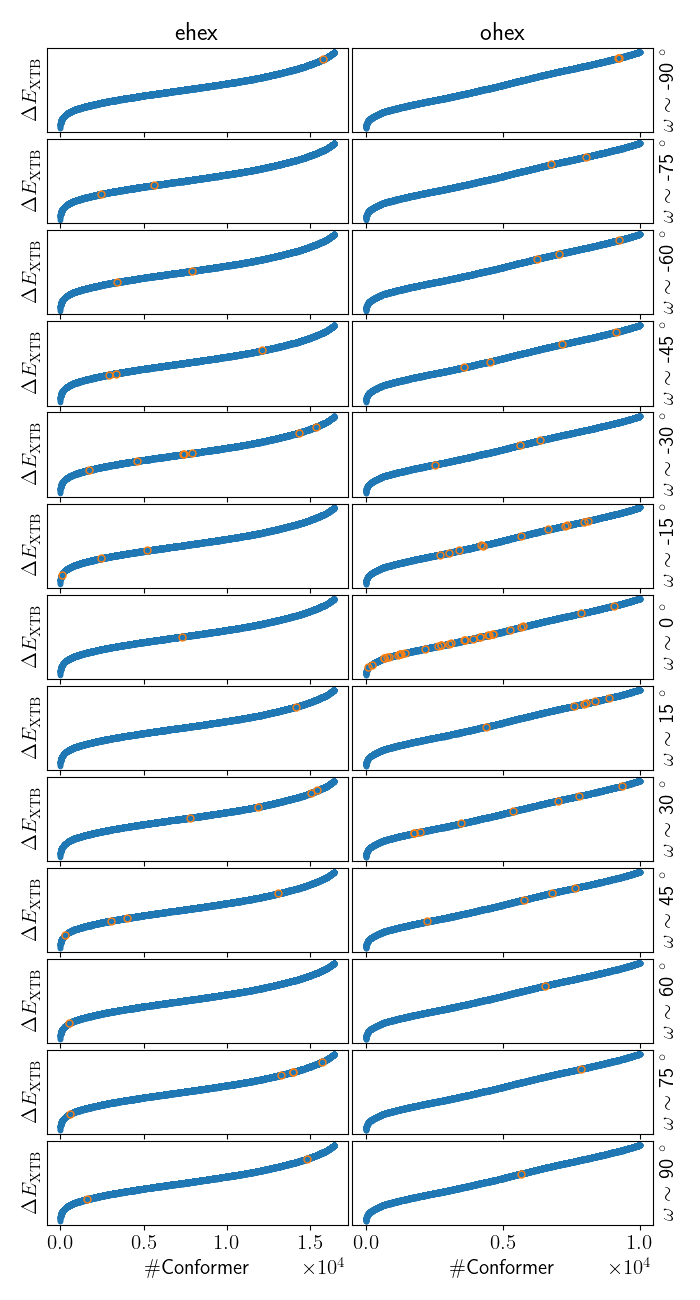

In [21]:
angles = np.arange(-90, 105, 15)

stable_conformers = {mol: {angle:{'atoms':None, 'energies':None, 'w':None} 
                           for angle in angles} 
                     for mol in ['ehex', 'ohex']}                

fig, axes = plt.subplots(len(angles), 2, figsize=(7, 13))
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            mask = np.zeros(3)
            
            atol_t1 = 2.5
            atol_t2 = 1.5
            while mask.sum() == 0:
                t1 = crest[mol][state]['t1']
                t2 = crest[mol][state]['t2']
    
                d1 = np.array([get_db1(atoms) for atoms in crest[mol][state]['aligned']])
                d2 = np.array([get_db2(atoms) for atoms in crest[mol][state]['aligned']])
                
                e = crest[mol][state]['energies']
                
                mask_t1 = np.isclose(t1, 0, atol=atol_t1)      # planar with bridge
                mask_t2 = np.isclose(t2, angle, atol=atol_t2)  # rotate
                
                mask_d1 = np.zeros(len(e), bool)
                mask_d1[d1 < 0]= True
    
                mask_d2 = np.zeros(len(e), bool)
                mask_d2[d2 < 0]= True
    
                mask = mask_t1 * mask_t2 * mask_d1 * mask_d2
    
                print(angle, mask_t1.sum(), mask_t2.sum(), mask_d1.sum(), mask_d2.sum(), mask.sum(), atol_t1, atol_t2)
                atol_t1 +=0.1
                atol_t2 +=0.1

                if atol_t2 > 7.5:
                    raise RuntimeError(f'Could not find conformer with {angle} angle')

            ax = axes[a, m]
            x = np.arange(len(e))
            ax.plot(x, e, '.')
            ax.plot(x[mask], e[mask], 'C1o', mfc='None', ms='5')

            stable_conformers[mol][angle]['atoms'] = [atoms for i, atoms in enumerate(crest[mol][state]['aligned']) if mask[i]]
            stable_conformers[mol][angle]['energies'] = crest[mol][state]['energies'][mask]
            stable_conformers[mol][angle]['w'] = crest[mol][state]['w'][mask]
            stable_conformers[mol][angle]['t1'] = crest[mol][state]['t1'][mask]
            stable_conformers[mol][angle]['t2'] = crest[mol][state]['t2'][mask]

for ax in axes[:, 1]:
    ax.set_yticklabels('')
for ax in axes[:-1, :].ravel():
    ax.set_xticklabels('')
for ax in axes.ravel():
    ax.set_yticks([])

for i, angle in enumerate(angles):
    axes[i, 0].set_ylabel('$\Delta E_\mathrm{XTB}$')
    axes[i, 1].set_ylabel(f'$\omega \sim$ {angle:d} $^\circ$')
    axes[i, 1].yaxis.set_label_position('right')
    
axes[0, 0].set_title('ehex')
axes[0, 1].set_title('ohex')
for ax in axes[-1, :]:
    ax.set_xlabel('\#Conformer')
fig.tight_layout(w_pad=0.1, h_pad=0.1)

In [22]:
stable_conformers[mol][angle].keys()

dict_keys(['atoms', 'energies', 'w', 't1', 't2'])

In [23]:
most_stable = {'ehex':[], 'ohex':[]}
most_stable_t = {'ehex':[[], []], 'ohex':[[], []]} # t1, t2
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for a, angle in enumerate(angles):
            conformers = stable_conformers[mol][angle]['atoms']
            e = stable_conformers[mol][angle]['energies']
            min_idx = np.argmin(e)
            
            most_stable[mol].append(conformers[min_idx])
            
            t1 = stable_conformers[mol][angle]['t1']
            t2 = stable_conformers[mol][angle]['t2']

            most_stable_t[mol][0].append(t1[min_idx])
            most_stable_t[mol][1].append(t2[min_idx])


nv.show_asetraj(most_stable['ehex'])

NGLWidget(max_frame=12)

In [313]:
nv.show_asetraj(most_stable['ohex'])

NGLWidget(max_frame=12)

Ok, it finally worked, but not without making a loop that slowly increases the angle windows in increments of 0.1 degrees until it can find a conformer in each window. 

Since there's basically only a single conformer left for each rotation, all bets are off with respect to R-group stability. So it will be extra interesting to compare the restrained-vs-free R-group MD simulations. 

For the free R-group, at this point we might as well have made a relaxed scan of the $\theta_1$ (or 2) dihedral, we would have gotten to the same point. 

Anyway, lets span the xyzs for now: 

In [334]:
outdir = 'data/rotation_spanned_fromcrest/'
os.makedirs(outdir, exist_ok=True)
for m, mol in enumerate(['ehex', 'ohex']):
    for state in ['s0']:  # skip q1 for now
        for atoms, t2 in zip(most_stable[mol], most_stable_t[mol][1]):
            fn = f'{mol}_{state}_theta{t2:03.0f}.xyz'
            write(outdir + fn, atoms, plain=True)
            
    

### Next steps:
- Calculate the scattering signal from these with and without R-groups (or use the scattering already in `crest`, just add it into `stable_conformers`)
- Try to identify a scattering pattern "fingerprint" of the _different_ mechanism idea: the _bridge_ twists to decouple the chromophores
- Span the **Benedikte**-model: 0-360 degrees between the two plane normals. Lowest-energy chromophore, regardless of bridge-role in total conjugation
  

In [24]:
crest['ehex']['s0'].keys()

dict_keys(['traj', 'energies', 't1', 't2', 'w', 'aligned', 'phis', 'psis', 'part0_dgtot', 'chis', 'gammas'])